In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import KernelPCA, PCA

# Load the dataset
df = pd.read_csv("combined_data.csv")

# Display the first 10 rows of the dataframe
print("Initial DataFrame:")
print(df.head(10))

Initial DataFrame:
      status  orbital_period  planet_radius  stellar_radius  insolation_flux  \
0  CONFIRMED       41.685500          2.578            1.08              NaN   
1  CONFIRMED       41.685500          2.230            0.93              NaN   
2  CONFIRMED       41.688644          2.355            0.96              NaN   
3  CANDIDATE        2.301830          1.120            0.76              NaN   
4  CANDIDATE        2.302368          1.313            0.71              NaN   
5  CANDIDATE        1.194749          4.190            0.57              NaN   
6  CANDIDATE        6.178369          9.913            0.79              NaN   
7  CANDIDATE        6.178870          8.840            0.85              NaN   
8  CANDIDATE        1.175890          0.860            0.31              NaN   
9  CANDIDATE       10.696600          1.450            0.59              NaN   

   equilibrium_temperature  stellar_effective_temperature  \
0                      NaN             

In [3]:
# Extract the target variable before encoding
y = df['status']

# Perform one-hot encoding for all categorical variables and drop the first column to avoid multicollinearity
df_encoded = pd.get_dummies(df.drop(columns=['status']), drop_first=True)

# Handle missing values by imputing with the mean of the column
imputer = SimpleImputer(strategy='mean')
df_encoded_imputed = pd.DataFrame(imputer.fit_transform(df_encoded), columns=df_encoded.columns)

# Encode the target variable separately
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Check the unique classes in the target variable
print("Encoded classes:", label_encoder.classes_)

# Check the columns of the encoded DataFrame
print("Columns of the encoded DataFrame:")
print(df_encoded.columns)

Encoded classes: ['CANDIDATE' 'CONFIRMED' 'FALSE POSITIVE' 'REFUTED']
Columns of the encoded DataFrame:
Index(['orbital_period', 'planet_radius', 'stellar_radius', 'insolation_flux',
       'equilibrium_temperature', 'stellar_effective_temperature',
       'stellar_surface_gravity'],
      dtype='object')


In [4]:
# Scale the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_encoded_imputed)

# Apply Kernel PCA
kpca = KernelPCA(kernel='rbf', n_components=10)  # You can adjust the kernel and n_components
df_kpca = kpca.fit_transform(df_scaled)

# Split the dataset into training and testing sets
test_size = 0.5
X_train, X_test, y_train, y_test = train_test_split(df_kpca, y_encoded, test_size=test_size, random_state=24)

# Define the grid of hyperparameters to search
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'lbfgs', 'sag']}

# GridSearchCV
grid_search = GridSearchCV(LogisticRegression(max_iter=5000), param_grid, cv=5)

# Perform grid search
grid_search.fit(X_train, y_train)

# Get best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'C': 10, 'solver': 'lbfgs'}


Accuracy: 0.5744072641668068


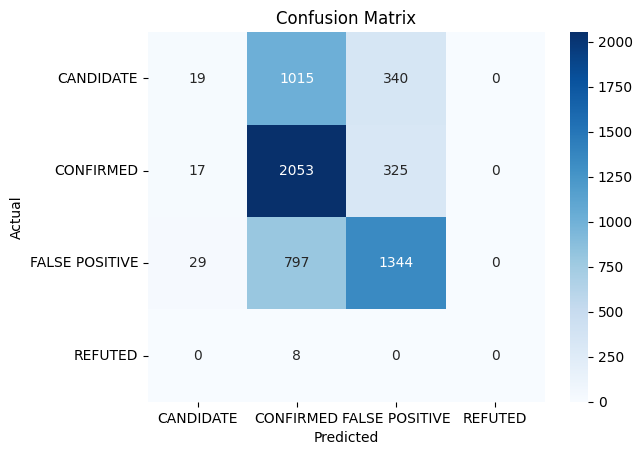

In [5]:
# Initialize logistic regression model with best hyperparameters
model = LogisticRegression(max_iter=5000, **best_params)

# Train the model
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Optional: Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [11]:
# Extract coefficients from the logistic regression model
coefficients = model.coef_[0]

# Since p-values are not directly available, we'll skip them for now
variable_stats = pd.DataFrame({'Variable': [f'PC{i+1}' for i in range(df_kpca.shape[1])], 'Coefficient': coefficients})

# Sort by absolute coefficient values
variable_stats_sorted = variable_stats.reindex(variable_stats['Coefficient'].abs().sort_values(ascending=False).index)

print("Top 3 most influential principal components:")
print(variable_stats_sorted.head(3))

# Perform standard PCA
n_samples, n_features = df_scaled.shape  # Get dimensions of scaled data
n_components = min(n_samples, n_features)  # Set appropriate number of components
pca = PCA(n_components=n_components)  # Initialize PCA with adjusted components
pca.fit(df_scaled)  # Fit PCA on scaled data

# Get the loadings (coefficients) of the original variables for each principal component
loadings = pca.components_.T

# Create a DataFrame to store loadings
loading_df = pd.DataFrame(loadings, index=df_encoded_imputed.columns, columns=[f'PC{i+1}' for i in range(n_components)])

# Print all columns to inspect their names
print(loading_df.columns)

# Assuming loading_df is your DataFrame with loadings from PCA or KPCA

# Number of top influential variables to print
top_n = 3

# Loop through each principal component
for pc in loading_df.columns:
    # Get the absolute values of loadings and sort them
    sorted_loadings = loading_df[pc].abs().sort_values(ascending=False)
    
    # Print the top influential variables for the current principal component
    print(f"Most influential variables for {pc}:")
    for i in range(top_n):
        var_name = sorted_loadings.index[i]
        loading_value = sorted_loadings.iloc[i]
        print(f"{var_name}: {loading_value:.4f}")
    print()  # Print a blank line for separation

Top 3 most influential principal components:
  Variable  Coefficient
6      PC7     1.409235
7      PC8     1.242842
5      PC6     1.206511
Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'], dtype='object')
Most influential variables for PC1:
stellar_radius: 0.5208
stellar_surface_gravity: 0.5100
equilibrium_temperature: 0.4970

Most influential variables for PC2:
stellar_effective_temperature: 0.8528
insolation_flux: 0.3562
stellar_radius: 0.2623

Most influential variables for PC3:
orbital_period: 0.9787
planet_radius: 0.1547
insolation_flux: 0.0825

Most influential variables for PC4:
planet_radius: 0.9469
insolation_flux: 0.2341
orbital_period: 0.1664

Most influential variables for PC5:
insolation_flux: 0.6670
stellar_surface_gravity: 0.5604
stellar_effective_temperature: 0.2930

Most influential variables for PC6:
equilibrium_temperature: 0.7901
stellar_radius: 0.4210
stellar_effective_temperature: 0.3706

Most influential variables for PC7:
stellar_radius: 0.6357
stellar_

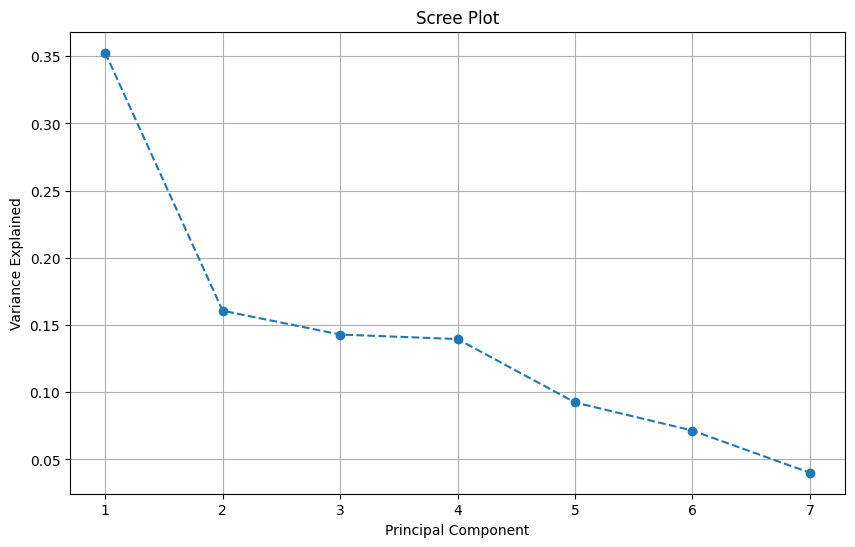

In [12]:
# Assuming pca is your fitted PCA model
explained_variance = pca.explained_variance_ratio_

# Plotting the scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid(True)
plt.show()

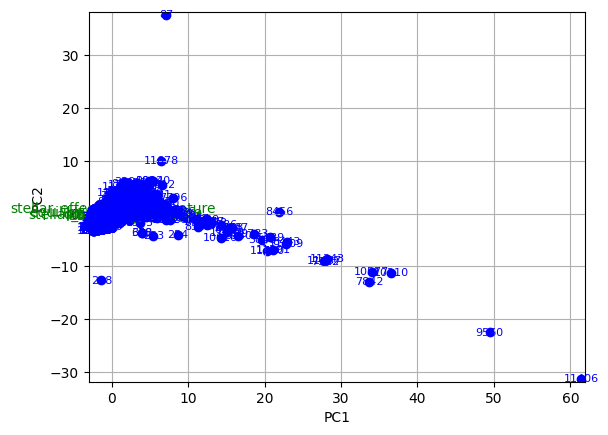

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def biplot(score, coeff, labels=None, marker_labels=None, ax=None):
    if ax is None:
        ax = plt.gca()

    ax.set_xlim(score[:, 0].min() - 0.5, score[:, 0].max() + 0.5)
    ax.set_ylim(score[:, 1].min() - 0.5, score[:, 1].max() + 0.5)
    
    # Plot arrows for principal component loadings
    for i in range(coeff.shape[0]):
        ax.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='r', alpha=0.5)
        if labels is not None:
            ax.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, labels[i], color='g', ha='center', va='center', fontsize=10)

    # Plot data points
    ax.scatter(score[:, 0], score[:, 1], marker='o', color='b')
    
    # Annotate points with markers if provided
    if marker_labels is not None:
        for i, label in enumerate(marker_labels):
            ax.text(score[i, 0], score[i, 1], label, color='b', fontsize=8, ha='center', va='center')
    
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.grid(True)
    
    return ax

# Example usage with labeled points
pca_score = pca.transform(df_scaled_standardized)

# Assuming df_encoded.columns are the variable names and pca.components_.T are the loadings
biplot(pca_score, pca.components_.T, labels=df_encoded.columns, marker_labels=np.arange(len(pca_score)))
plt.show()